<h2>Importing all required libraries</h2>

In [ ]:
import sys
import gc
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm.auto import tqdm
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from transformers import PreTrainedTokenizerFast
from transformers import pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

<h2>Importing the final data</h2>

In [ ]:
with open('final_data.json') as f:
    data = json.load(f)

<h2>Converting the data into a dataframe and assigning a column name for the text data</h2>

In [ ]:
df1 = pd.DataFrame(data)
df1 = df1.rename(columns={'0': "file"})

<h2>Assigning labels to the data, the first 100 files are AI generated, and the next 100 are human written.</h2>

In [ ]:
df1 = df1.assign(label=1)
for i in range(400,800):
    df1.label[i] = 0
df = df1.reindex()
df.reset_index(drop=True, inplace=True)

<h2>Setting configuration parameters</h2>

In [ ]:
LOWERCASE = False
VOCAB_SIZE = 30522

<h2>Creating Tokenizer, Normalizing and Pre-Tokenizing</h2>

In [ ]:
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

<h2>Configuring BPE Trainer</h2>

In [ ]:
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

<h2>Splitting the dataset into training and testing sets</h2>

In [ ]:
X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

<h2>Training the tokenizer</h2>

In [ ]:
dataset = Dataset.from_pandas(X_test[['file']])
def train_corp_iter():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["file"]
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

<h2>Creating PreTrained Tokenizer object using the trained raw tokenizer</h2>

In [ ]:
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

<h2>Tokenizing Testing and Training data</h2>

In [ ]:
tokenized_texts_test = []
for text in tqdm(X_test['file'].tolist()):
    tokenized_texts_test.append(tokenizer.tokenize(text))

tokenized_texts_train = []
for text in tqdm(X_train['file'].tolist()):
    tokenized_texts_train.append(tokenizer.tokenize(text))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

<h2>TF-IDF Vectorizer Configuration and Fitting on Test Data</h2>

In [ ]:
def dummy(text):
    return text
vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer = 'word',
    tokenizer = dummy,
    preprocessor = dummy,
    token_pattern = None, strip_accents='unicode')
vectorizer.fit(tokenized_texts_test)

TfidfVectorizer(lowercase=False, ngram_range=(3, 5),
                preprocessor=<function dummy at 0x7a65af393e20>,
                strip_accents='unicode', sublinear_tf=True, token_pattern=None,
                tokenizer=<function dummy at 0x7a65af393e20>)

<h2>Storing all the vocabulary</h2>

In [ ]:
vocab = vectorizer.vocabulary_

<h2>Reconfiguring Vectorizer and transforming training dataset, and testing dataset</h2>

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
                            analyzer = 'word',
                            tokenizer = dummy,
                            preprocessor = dummy,
                            token_pattern = None, strip_accents='unicode'
                            )

tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

<h2>Model configuration and training</h2>

In [ ]:
clf = MultinomialNB(alpha=0.02)
sgd_model = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber")
p6 = {'n_iter': 2, 'verbose': -1, 'objective': 'cross_entropy', 'metric': 'auc',
          'learning_rate': 0.05073909898961407, 'colsample_bytree': 0.726023996436955,
          'colsample_bynode': 0.5803681307354022, 'lambda_l1': 8.562963348932286,
          'lambda_l2': 4.893256185259296, 'min_data_in_leaf': 115, 'max_depth': 23, 'max_bin': 898}
lgb = LGBMClassifier(**p6)
cat = CatBoostClassifier(iterations=2,
                             verbose=0,
                             l2_leaf_reg=6.6591278779517808,
                             learning_rate=0.005689066836106983,
                             subsample=0.4,
                             allow_const_label=True, loss_function='CrossEntropy')

weights = [0.4, 0.3,0.15,0.15]
ensemble = VotingClassifier(estimators=[('mnb', clf),
                                          ('sgd', sgd_model),
                                           ('lgb', lgb),
                                            ('cat', cat)],
                              weights=weights, voting='soft', n_jobs=-1)
ensemble.fit(tf_train, y_train)
gc.collect()

<h2>Getting and formatiing predictions on test dat. And Plottin the roc curve based of the probabilities.</h2>

model 1 AUC score: 0.9606342537014806


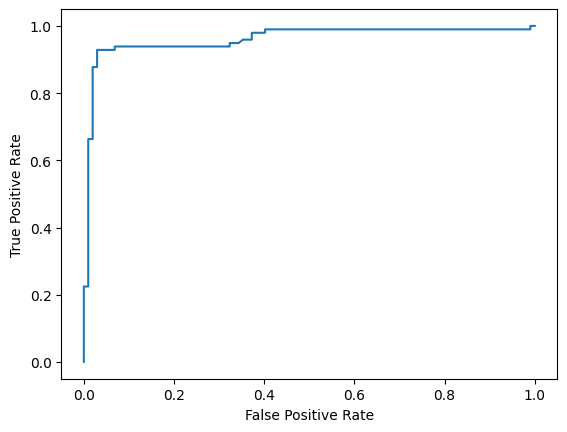

In [ ]:
final_preds = ensemble.predict_proba(tf_test)[:, 1]
formatted_values = [f"{val:f}" for val in final_preds]
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(y_test.to_numpy(), np.array(formatted_values).astype(float))
print(f'model 1 AUC score: {roc_auc_score(y_test.to_numpy(), np.array(formatted_values).astype(float))}')
floored_values = []
for val in formatted_values:
  if float(val)<0.65:
    floored_values.append(0)
  else:
    floored_values.append(1)

<h2>Computing precision, recall, and F1 score for class 0 and class 1. </h2>

In [ ]:
test_labels = y_test.tolist()
cm = confusion_matrix(test_labels, floored_values)
precision_0 = precision_score(test_labels, floored_values, pos_label=0)
recall_0 = recall_score(test_labels, floored_values, pos_label=0)
f1_0 = f1_score(test_labels, floored_values, pos_label=0)
precision_1 = precision_score(test_labels, floored_values, pos_label=1)
recall_1 = recall_score(test_labels, floored_values, pos_label=1)
f1_1 = f1_score(test_labels, floored_values, pos_label=1)

print("Confusion Matrix:")
print(cm)
print("\nClass 0:")
print("Precision:", precision_0)
print("Recall:", recall_0)
print("F1 Score:", f1_0)
print("\nClass 1:")
print("Precision:", precision_1)
print("Recall:", recall_1)
print("F1 Score:", f1_1)

Confusion Matrix:
[[99  3]
 [ 8 90]]

Class 0:
Precision: 0.9252336448598131
Recall: 0.9705882352941176
F1 Score: 0.9473684210526315

Class 1:
Precision: 0.967741935483871
Recall: 0.9183673469387755
F1 Score: 0.9424083769633509


<h2>Classification function based on the threshold value</h2>

In [ ]:
def classification(value):
  k = tokenizer.tokenize(value)
  t=[]
  t.append(k)
  t_test = vectorizer.transform(t)
  fin = ensemble.predict_proba(t_test)[:, 1]
  if float(fin)<0.65:
    val = 0
  else:
    val = 1
  return [fin[0], val, explanation]

<h2>Facebook Bart Abstractive Summarizer</h2>

In [ ]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

<h2>Function to call the Summarizer</h2>

In [ ]:
def summarization(value):
  summ = d(value, max_length=130, min_length=30, do_sample=False)
  return summ[0]['summary_text']